# MSCF 46982 Market Microstructure and Algorithmic Trading

Fall 2025 Mini 2

Introduction to Time Series Analysis in Q

Copyright &copy; 2025 Nick Psaris. All Rights Reserved

# TOC
- [SSL_VERIFY_SERVER](#SSL_VERIFY_SERVER)
- [Initialize](#Initialize)
- [Crypto Trades](#Crypto-Trades)
- [Load CSVs](#Load-CSVs)
- [KDB+ Types](#KDB+-Types)
- [Bulk Loading](#Bulk-Loading)
- [The K Struct](#The-K-Struct)
- [SQL](#SQL)
- [Q-SQL](#Q-SQL)
- [Volatility Estimator](#Volatility-Estimator)
- [Pivoting](#Pivoting)
- [Integration with Python](#Integration-with-Python)
- [Plotting](#Plotting)


# SSL_VERIFY_SERVER
- In order to permit Kdb+ to download files using the https protocol,
  q must be configured with (amoung other other things) the location
  of the certificate authority certificates (CA_CERT) files
- We can see the existing SSL configuration with the `-26!` operator
- The anaconda install should have this configured properly.  If
  loading of https sites still does not work, we can disable server
  verification by setting the `SSL_VERIFY_SERVER` variable to "NO'
  **before** running `jupyter notebook` or `jupyter lab`
- You can kill the server, set the variable and restart jupyter

In [1]:
import os
os.environ['PYKX_JUPYTERQ'] = 'true'
os.environ['PYKX_4_1_ENABLED'] = 'true'
import pykx as kx

PyKX now running in 'jupyter_qfirst' mode. All cells by default will be run as q code. 
Include '%%py' at the beginning of each cell to run as python code. 


In [2]:
getenv `SSL_VERIFY_SERVER

In [3]:
(-26!)[]

SSLEAY_VERSION   | OpenSSL 3.3.1 4 Jun 2024
SSL_CERT_FILE    | /Users/nick/miniconda3/ssl/server-crt.pem
SSL_CA_CERT_FILE | /Users/nick/miniconda3/ssl/cacert.pem
SSL_CA_CERT_PATH | /Users/nick/miniconda3/ssl
SSL_KEY_FILE     | /Users/nick/miniconda3/ssl/server-key.pem
SSL_CIPHER_LIST  | ECDHE-ECDSA-CHACHA20-POLY1305:ECDHE-RSA-CHACHA20-POLY1305:..
SSL_VERIFY_CLIENT| NO
SSL_VERIFY_SERVER| YES


## Mac/Linux
```shell
export SSL_VERIFY_SERVER="NO"
jupyter-lab
```
or
```shell
SSL_VERIFY_SERVER="NO" jupyter-lab
```

## Windows
```shell
set SSL_VERIFY_SERVER=NO
jupyter-lab
```

# Initialize

- We start by initializing the number of rows and columns displayed

In [4]:
\c 5 100

# Crypto Trades

- Raw Trades from the Bitstamp exchange are available for
  [download][bitstamp] (but availability of more recent data seems to
  require an account)
- First we store the base https path

[bitstamp]: https://www.cryptodatadownload.com/data/bitstamp/

In [5]:
b:"https://www.cryptodatadownload.com/cdd/tradeprints/"

- Then we generate a list of all available data files

In [6]:
t:string `BTC`BCH`ETH`LTC`XRP
c:t,\:"USD"
c,:t,\:"EUR"
c,:(1_t),\:"BTC"
show f:b,/:c,\:"_Bitstamp_Q1_2021_prints.csv.gz"


"https://www.cryptodatadownload.com/cdd/tradeprints/BTCUSD_Bitstamp_Q1_2021_prints.csv.gz"
"https://www.cryptodatadownload.com/cdd/tradeprints/BCHUSD_Bitstamp_Q1_2021_prints.csv.gz"
"https://www.cryptodatadownload.com/cdd/tradeprints/ETHUSD_Bitstamp_Q1_2021_prints.csv.gz"
"https://www.cryptodatadownload.com/cdd/tradeprints/LTCUSD_Bitstamp_Q1_2021_prints.csv.gz"
"https://www.cryptodatadownload.com/cdd/tradeprints/XRPUSD_Bitstamp_Q1_2021_prints.csv.gz"
"https://www.cryptodatadownload.com/cdd/tradeprints/BTCEUR_Bitstamp_Q1_2021_prints.csv.gz"
"https://www.cryptodatadownload.com/cdd/tradeprints/BCHEUR_Bitstamp_Q1_2021_prints.csv.gz"
..


- `.Q.hg` reads data from web sites
- `.Q.gz` uncompress bytes compressed with gzip

In [7]:
show s:.Q.gz .Q.hg first f

"unix,date,symbol,price,amount,dollar_amount,type,trans_id\n1609373270,2020-12-31 00:07:50,BTC/US..


# Load CSVs
- The `0:` operator parses text
- The `1:` operator parses binary
- Delimiter character is specified as second element of left operand
- Letters represent the data type
- After we review the [file specification][fs], we can pick the
  correct data types for each desired column (and skip the ones we
  don't want)

[fs]: https://www.cryptodatadownload.com/data/bitstamp/ "File specification"


In [8]:
("P SFFFS";1#",") 0: s

unix                          symbol  price    amount     dollar_amount type
----------------------------------------------------------------------------
2020.12.31D00:07:50.000000000 BTC/USD 29063.9  0.00658    191.2405      buy 
2020.12.31D00:07:49.000000000 BTC/USD 29047.92 0.09833333 2856.379      sell
2020.12.31D00:07:48.000000000 BTC/USD 29061.92 0.00093228 27.09385      sell
2020.12.31D00:07:41.000000000 BTC/USD 29088.7  0.0010238  29.78101      buy 
2020.12.31D00:07:37.000000000 BTC/USD 29084.04 0.398706   11595.98      buy 
..


# Kdb+ Types
- Spaces ignore columns in file (which can speed up loading a few
  columns from a large file)

| num | char | size | literal | null | inf | name    | num | char | size | literal            | null | inf | name      |
|-----|------|------|---------|------|-----|---------|-----|------|------|--------------------|------|-----|-----------|
| 1   | b    | 1    | 0b      | -    | -   | boolean | 11  | s    | .    | `                  | `    | -   | symbol    |
| 2   | g    | 16   | -       | 0Ng  | -   | guid    | 12  | p    | 8    | dateDtimespan      | 0Np  | 0Wp | timestamp |
| 3   | -    | -    | -       | -    | -   | unused  | 13  | m    | 4    | 2000.01m           | 0Nm  | 0Wm | month     |
| 4   | x    | 1    | 0x0     | -    | -   | byte    | 14  | d    | 4    | 2000.01.01         | 0Nd  | 0Wd | date      |
| 5   | h    | 2    | 0h      | 0Nh  | 0Wh | short   | 15  | z    | 8    | dateTtime          | 0Nz  | 0Wz | datetime  |
| 6   | i    | 4    | 0i      | 0Ni  | 0Wi | int     | 16  | n    | 8    | 00:00:00.000000000 | 0Nn  | 0Wn | timespan  |
| 7   | j    | 8    | 0       | 0N   | 0W  | long    | 17  | u    | 4    | 00:00              | 0Nu  | 0Wu | minute    |
| 8   | e    | 4    | 0e      | 0Ne  | 0we | real    | 18  | v    | 4    | 00:00:00           | 0Nv  | 0Wv | second    |
| 9   | f    | 8    | 0.0/0f  | 0n   | 0w  | float   | 19  | t    | 4    | 00:00:00.000       | 0Nt  | 0Wt | time      |
| 10  | c    | 1    | " "     | " "  | -   | char    | 20  | -    | -    | -                  | -    | -   | enum      |

# Bulk Loading
- The `xcol` operator renames columns with a symbol list
- The `xasc` operator sorts a table by one (or more) columns
- The `raze` operator removes one layer of nesting and is often used
  together with `each`


In [9]:
loadf:{
 t:("P SFFFS";1#",") 0: .Q.gz .Q.hg 0N!x;
 t:`time xasc `time`sym`price`qty`notional`side xcol t;
 t}
t:raze loadf each f where f like "*USD*"

"https://www.cryptodatadownload.com/cdd/tradeprints/BTCUSD_Bitstamp_Q1_2021_prints.csv.gz"
"https://www.cryptodatadownload.com/cdd/tradeprints/BCHUSD_Bitstamp_Q1_2021_prints.csv.gz"
"https://www.cryptodatadownload.com/cdd/tradeprints/ETHUSD_Bitstamp_Q1_2021_prints.csv.gz"
"https://www.cryptodatadownload.com/cdd/tradeprints/LTCUSD_Bitstamp_Q1_2021_prints.csv.gz"
"https://www.cryptodatadownload.com/cdd/tradeprints/XRPUSD_Bitstamp_Q1_2021_prints.csv.gz"


In [10]:
t

time                          sym     price    qty        notional side
-----------------------------------------------------------------------
2020.12.31D00:00:09.000000000 BTC/USD 28897.2  0.1680757  4856.916 buy 
2020.12.31D00:00:10.000000000 BTC/USD 28902.72 0.3984182  11515.37 buy 
2020.12.31D00:00:16.000000000 BTC/USD 28893.97 0.6625301  19143.12 sell
2020.12.31D00:00:18.000000000 BTC/USD 28893.21 0.0007602  21.96462 buy 
2020.12.31D00:00:20.000000000 BTC/USD 28910.54 0.00104167 30.11524 buy 
..


- The `meta` operator displays the **t**ypes, **f**oreign keys and
  **a**ttributes of each column


In [11]:
meta t

c       | t f a
--------| -----
time    | p    
sym     | s    
price   | f    
qty     | f    
notional| f    
side    | s    


# Volatility Estimator

The Parkinson volatility estimator (developed in 1980) uses the high
and low values within intervals.

$$
\sigma(n)_{parkinson}=\sqrt{\frac{1}{4\ln 2}\frac{1}{n}\sum_{i=0}^n \left(\ln(\frac{h_i}{l_i})\right)^2}
$$

A few drawbacks of the estimator are that it:
- assumes markets are continuous and **tends to underestimate
  volatility** because it ignores inter-interval jumps
- assumes zero drift and **may overestimate volatility** in a trending
  market



We will define `parkinson` to compute the *variance* (volatility
squared) - without averaging, so we can compute a moving average
ourselves, before annualzing and converting to a volatility.

$$
\sigma_{parkinson}^2=\frac{1}{4\ln 2}\left(\ln(\frac{h}{l})\right)^2
$$

Variances (not standard deviations) can be averaged

In [12]:
parkinson:{[h;l](1f%4f*log 2f)*r*r:log h%l}

In [13]:
x:til 10000000
\ts x xexp 2
\ts x*x

52 268435344
3 134217984


# SQL
- SQL stands for Structured Query Language
- SQL is used for accessing and manipulating data stored in relational
  databases
- KDB Insights supports [ANSI SQL][]
- SQL can be used by prefixing commands with s) or the `.s.e` operator
- [SQL data types][] are mapped to Q data types
- Date/Times must be passed as string literals

[ansi sql] https://code.kx.com/insights/core/sql.html "ANSI SQL"
[sql data types] https://code.kx.com/insights/core/sql/data.html "SQL Data Types"



In [34]:
s) select * from t where sym = 'BTC/USD' and time >= '2021.03.31' order by time desc


time                          sym     price    qty        notional side
-----------------------------------------------------------------------
2021.03.31D23:59:59.000000000 BTC/USD 58782.58 0.03833    2253.136 sell
2021.03.31D23:59:58.000000000 BTC/USD 58782.58 0.01947476 1144.777 sell
2021.03.31D23:59:55.000000000 BTC/USD 58797.37 0.012      705.5684 buy 
2021.03.31D23:59:54.000000000 BTC/USD 58785.77 0.1566     9205.852 buy 
2021.03.31D23:59:50.000000000 BTC/USD 58795.34 0.012      705.5441 buy 
..


In [35]:
.s.e "select * from t"

time                          sym     price    qty        notional side
-----------------------------------------------------------------------
2020.12.31D00:00:09.000000000 BTC/USD 28897.2  0.1680757  4856.916 buy 
2020.12.31D00:00:10.000000000 BTC/USD 28902.72 0.3984182  11515.37 buy 
2020.12.31D00:00:16.000000000 BTC/USD 28893.97 0.6625301  19143.12 sell
2020.12.31D00:00:18.000000000 BTC/USD 28893.21 0.0007602  21.96462 buy 
2020.12.31D00:00:20.000000000 BTC/USD 28910.54 0.00104167 30.11524 buy 
..


# Q-SQL

- Q-SQL is similar to SQL but integrates the full power the the Q
  language
- Scopes operations to the table, reduces repetition and is more
  natural

Compare SQL:

`select * from t where a = b`

with Q-SQL:

`select from t where a=b`

with Python:

`df[df["a"]==df["b"]]`


## Select
- A simple `select` query does not copy the data
- Standard SQL would read `select * from t`
- Can be used on:
  + variables `t`
  + variable names ```t``
  + database paths ```:/path/to/db/``

In [16]:
select from t

time                          sym     price    qty        notional side
-----------------------------------------------------------------------
2020.12.31D00:00:09.000000000 BTC/USD 28897.2  0.1680757  4856.916 buy 
2020.12.31D00:00:10.000000000 BTC/USD 28902.72 0.3984182  11515.37 buy 
2020.12.31D00:00:16.000000000 BTC/USD 28893.97 0.6625301  19143.12 sell
2020.12.31D00:00:18.000000000 BTC/USD 28893.21 0.0007602  21.96462 buy 
2020.12.31D00:00:20.000000000 BTC/USD 28910.54 0.00104167 30.11524 buy 
..


- Kdb+ employs [copy on write][cow] memory management
- Selecting columns keeps references to the original columns
- Even renaming columns does not allocate new memory
- Only modified/calculated columns allocate new memory
- Column names are reused if not reassigned
- -16! is an [internal Q function][iqf]
  
[cow]: https://en.wikipedia.org/wiki/Copy-on-write "Copy on write"
[iqf]: https://code.kx.com/v2/basics/internal/ "Internal Q functions"


In [17]:
show s:select time.date,sym from t
-16!s`date // one reference
-16!s`sym  // two references


1idate       sym    
------------------
2020.12.31 BTC/USD
2020.12.31 BTC/USD
2020.12.31 BTC/USD
2020.12.31 BTC/USD
2020.12.31 BTC/USD
..

2i


## Where
- Using a `where` clause allocates new memory for all returned columns
- `where` clauses are executed in sequence -- you are the query
  optimizer
- `where` clauses are executed left to right (but still right to left
  within each clause)


In [18]:
select from t where sym like "ETH*",time>12:00

time                          sym     price  qty      notional side
-------------------------------------------------------------------
2020.12.31D12:01:12.000000000 ETH/USD 746.66 1.68     1254.389 buy 
2020.12.31D12:01:18.000000000 ETH/USD 746.7  13.399   10005.03 buy 
2020.12.31D12:01:22.000000000 ETH/USD 746.91 11.637   8691.791 buy 
2020.12.31D12:01:30.000000000 ETH/USD 746.91 0.485    362.2514 buy 
2020.12.31D12:01:32.000000000 ETH/USD 746.91 1.273001 950.8175 buy 
..


## By

- Aggregations can be computed by using the `by` clause
- The `xbar` operator *floors* each `y` the nearest multiple of
  `x` and is often used to 'bin' `by` clauses
- By clauses sort by the 'by' column(s)


In [19]:
s:select o:first price,h:max price,l:min price,c:last price by sym, 0D01 xbar time from t

In [20]:
/ demonstration of xbar flooring down to nearest multiple
(x;.1 xbar x:100?1f)

0.3927524 0.5170911 0.5159796 0.4066642 0.1780839 0.3017723 0.785033 0.5347096 0.7111716 0.411597..
0.3       0.5       0.5       0.4       0.1       0.3       0.7      0.5       0.7       0.4     ..


## Selecting without aggregating

- A common mistake is to perform a `select` with a `by` clause to
  reorder columns or add a primary key
- This doesn't visually change the table, but inspecting the `meta`
  reveals that each column is now a vector of values
- Lowercase types represent a single value per row, while uppercase
  types represent a vector
- If you don't use an aggregating function (like `sum` or `first`),
  you'll end up columns that contain vectors and possible ```type``
  errors on future calculations


In [21]:
show v:select o,h,l,c by sym,time from s / looks good
meta v                                   / but meta says otherwise

c   | t f a
----| -----
sym | s   p
time| p    
o   | F    
h   | F    
l   | F    
c   | F    sym     time                         | o      h      l      c     
-------------------------------------| ---------------------------
BCH/USD 2020.12.31D00:00:00.000000000| 358.68 361.16 355.41 355.67
BCH/USD 2020.12.31D01:00:00.000000000| 355.73 355.73 346.44 351.52
BCH/USD 2020.12.31D02:00:00.000000000| 351.14 352.78 349.87 351.12
BCH/USD 2020.12.31D03:00:00.000000000| 351.08 355.26 350.56 354.3 
BCH/USD 2020.12.31D04:00:00.000000000| 354.69 359.4  352.96 354.23
..



## Update

- The `update` operator modifies existing columns, or adds new one

In [22]:
show s:update vol:sqrt 365f*24*5 mavg parkinson[h;l] by sym from s


sym     time                         | o      h      l      c      vol      
-------------------------------------| -------------------------------------
BCH/USD 2020.12.31D00:00:00.000000000| 358.68 361.16 355.41 355.67 0.9021066
BCH/USD 2020.12.31D01:00:00.000000000| 355.73 355.73 346.44 351.52 1.230094 
BCH/USD 2020.12.31D02:00:00.000000000| 351.14 352.78 349.87 351.12 1.039716 
BCH/USD 2020.12.31D03:00:00.000000000| 351.08 355.26 350.56 354.3  0.975119 
BCH/USD 2020.12.31D04:00:00.000000000| 354.69 359.4  352.96 354.23 0.9835007
..


- The `mavg` operator computes a moving average that 'warms up' to the
  window size


In [23]:
5 mavg 0N!til 10
5 mdev 1 2 0N 4 5 6

0 0.5 1 1.5 2 3 4 5 6 7
0 0.5 0.5 1.247219 1.581139 1.47902
0 1 2 3 4 5 6 7 8 9


# Pivoting

- We can use the `pivot` function to create a pivot table (similar to excel)
- The `pivot` function accepts a keyed table as input and uses the:
  - last column of the table as the data
  - last key column as the column headers
  - all but the last key column as keys to the pivoted table
- Only pivot the data as the last step before visualization

In [24]:
/ pivot table
pivot:{[t]
 u:`$string asc distinct last f:flip key t;
 pf:{x#(`$string y)!z};
 p:?[t;();g!g:-1_ k;(pf;`u;last k:key f;last key flip value t)];
 p} 

In [25]:
show p:pivot 2!select time,sym,vol from s / where time > -5D + last time

time                         | BCH/USD   BTC/USD   ETH/USD   LTC/USD  XRP/USD 
-----------------------------| -----------------------------------------------
2020.12.31D00:00:00.000000000| 0.9021066 0.7858585 0.7399635 1.215316 2.213445
2020.12.31D01:00:00.000000000| 1.230094  1.463508  1.081043  1.744908 2.132807
2020.12.31D02:00:00.000000000| 1.039716  1.212241  0.939875  1.468    2.142943
2020.12.31D03:00:00.000000000| 0.975119  1.131803  0.8762951 1.297083 1.944063
2020.12.31D04:00:00.000000000| 0.9835007 1.054437  0.8235743 1.212783 1.868048
..


# Integration with Python
- Prefixing a block of code with `%%py` 'magic' causes the
  resulting block to be evaluated within python


In [26]:
%%py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('default')
mpl.rcParams["figure.figsize"] = [15,5]


- the `.pykx.topd` function converts a q table to a pandas dataframe
- the `.pykx.set` function stores an object into the python `__main__` memory spaces
- the `p)` prefix allows us to call python code from a q cell


In [27]:
.pykx.set[`df] .pykx.topd p
p)print(df)


                      BCH/USD   BTC/USD   ETH/USD   LTC/USD   XRP/USD
time                                                                 
2020-12-31 00:00:00  0.902107  0.785858  0.739963  1.215316  2.213445
2020-12-31 01:00:00  1.230094  1.463508  1.081043  1.744908  2.132807
2020-12-31 02:00:00  1.039716  1.212241  0.939875  1.468000  2.142943
2020-12-31 03:00:00  0.975119  1.131803  0.876295  1.297083  1.944063
2020-12-31 04:00:00  0.983501  1.054437  0.823574  1.212783  1.868048
...                       ...       ...       ...       ...       ...
2021-03-31 19:00:00  0.733494  0.740270  0.809795  0.667434  0.828413
2021-03-31 20:00:00  0.925481  0.722824  0.984437  0.759537  1.170541
2021-03-31 21:00:00  0.868317  0.657439  0.985957  0.721894  1.198196
2021-03-31 22:00:00  0.908490  0.663524  1.056629  0.744056  1.151440
2021-03-31 23:00:00  0.959419  0.659057  0.937321  0.762705  1.207640

[2184 rows x 5 columns]


# Plotting
- Calling the dataframe 'plot' method automatically generates legend
  entries and axes based on the dataframe columns and index


<Axes: title={'center': 'Intraday Volatility'}, xlabel='time'>

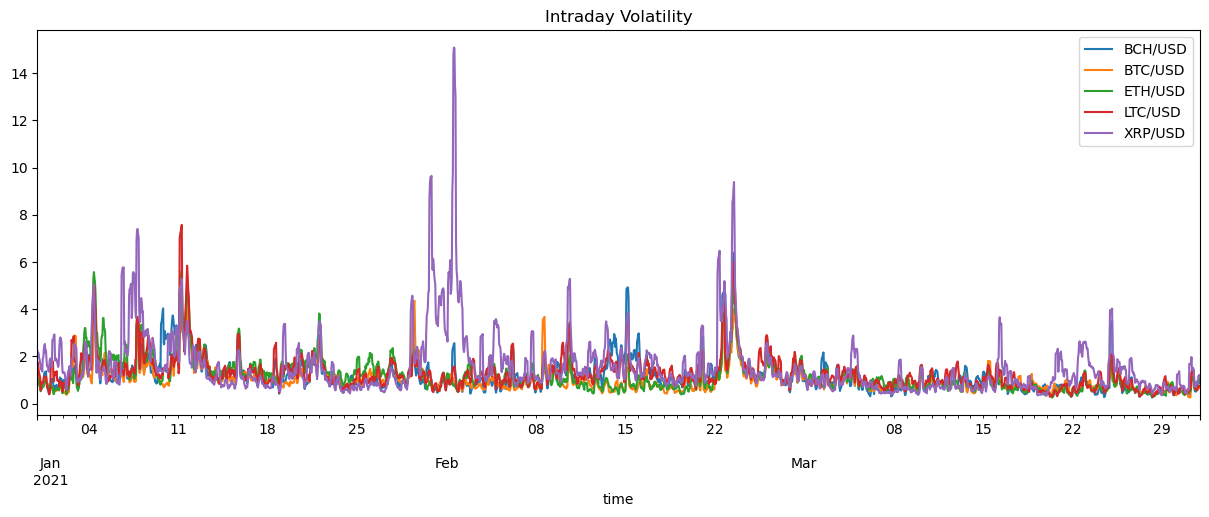

In [28]:
%%py
df.plot(title='Intraday Volatility')
